<a href="https://colab.research.google.com/github/nekrut/msmb_python/blob/master/chapter1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install seaborn --upgrade

    100% |████████████████████████████████| 215kB 6.6MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [90]:
pip install numpy --upgrade

    100% |████████████████████████████████| 17.3MB 1.7MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#  1. Generative Models for Discrete Data

------

In molecular biology, many situations involve counting events: how many codons use a certain spelling, how many reads of DNA match a reference, how many CG dinucleotides are observed in a DNA sequence. These counts give us discrete variables, as opposed to quantities such as mass and intensity that are measured on continuous scales.

If we know the rules that the mechanisms under study follow, even if the outcomes are random, we can generate the probabilities of any events we are interested in by computations and standard probability laws. This is a top-down approach based on deduction and our knowledge of how to manipulate probabilities. In Chapter 2, you will see how to combine this with data-driven (bottom-up) statistical modeling.



## 1.1. Goals for this chapter
------
In this chapter we will:

 - Learn how to obtain the probabilities of all possible outcomes from a given model and see how we can compare the theoretical frequencies with those observed in real data.
 - Explore a complete example of how to use the Poisson distribution to analyse data on epitope detection.
 - See how we can experiment with the most useful generative models for discrete data: Poisson, binomial, multinomial.
 - Use the Python for computing probabilities and counting rare events.
 - Generate random numbers from specified distributions.


## 1.2. A real example
--------
Let’s dive into a real example, where we know the probability model for the process. We are told that mutations along the genome of HIV (Human Immunodeficiency Virus) occur at random with a rate of $5 \times 10^{-4}$ per nucleotide per replication cycle (generation). This means that after one cycle, the number of mutations in a genome of about $10^{4} = 10,000$ nucleotides will follow a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) (we will give more details later about this type of probability distribution). with rate 5. What does that tell us? This probability model predicts that the number of mutations over one replication cycle will be close to 5, and that the variability of this estimate is $\sqrt{5}$
(the standard error). We now have baseline reference values for both the number of mutations we expect to see in a typical HIV strain and its variability.

In fact, we can deduce even more detailed information. If we want to know how often 3 mutations could occur under the Poisson(5) model, we can use a Python function to generate the probability of seeing $x = 3$ events, taking the value of the rate parameter of the Poisson distribution, called lambda ($\lambda$). (Greek letters such as $\lambda$ and $\mu$ often denote important parameters that characterize the probability distributions we use.), to be 5:
.

In [0]:
from scipy.stats import poisson

In [4]:
# Here k = 3 and lambda = 5

poisson.pmf(3,5)

0.1403738958142805

This says the chance of seeing exactly three events is around 0.14, or about 1 in 7.

If we want to generate the probabilities of all values from 0 to 12, we do not need to write a loop. We can simply set the first argument to be the vector of these 13 values, using `numpy`'s `arange` function. We can see the probabilities by plotting them (Figure 1.1). As with this figure, most figures in the margins of this book are created by the code shown in the text.

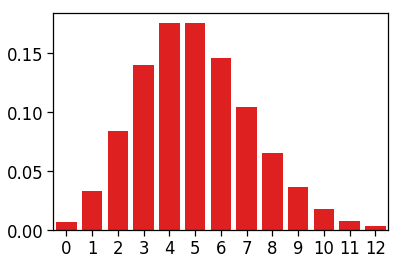

In [5]:
sns.barplot(x=np.arange(13), y=poisson.pmf(np.arange(13),5), color='r')

> **Figure 1.1**: Probabilities of seeing 0,1,2,…,12 mutations, as modeled by the Poisson(5) distribution. The plot shows that we will often see 4 or 5 mutations but rarely as many as 12. The distribution continues to higher numbers (13,....), but the probabilities will be successively smaller, and here we don’t visualize them.

Mathematical theory tells us that the Poisson probability of seeing the value $x$ is given by the formula $\frac{e^{- \lambda} \lambda^{x}}{x!}$ Here, we’ll discuss theory from time to time, but give preference to displaying concrete numeric examples and visualizations like Figure 1.1. 

The Poisson distribution is a good model for rare events such as mutations. Other useful probability models for discrete events are the Bernoulli, binomial and multinomial distributions. We will explore these models in this chapter.

## 1.3. Using discrete probability models
------
A point mutation can either occur or not; it is a binary event. The two possible outcomes (yes, no) are called the levels of the categorical variable.

Think of a categorical variable as having different alternative values. These are the levels, similar to the different alternatives at a gene locus: alleles.

Not all events are binary. For example, the genotypes in a diploid organism can take three levels (`AA`, `Aa`, `aa`).

Sometimes the number of levels in a categorical variable is very large; examples include the number of different types of bacteria in a biological sample (hundreds or thousands) and the number of codons formed of 3 nucleotides (64 levels).

When we measure a categorical variable on a sample, we often want to tally the frequencies of the different levels in a vector of counts. `Pandas` has a special factorizing function. Here we capture the different blood genotypes for 19 subjects in a vector which we tabulate:

In [0]:
genotype = pd.Series(["AA","AO","BB","AO","OO","AO","AA","BO","BO","AO","BB","AO","BO","AB","OO","AB","BB","AO","AO"])

In [0]:
genotypeF = genotype.value_counts()

In [8]:
genotypeF

AO    7
BO    3
BB    3
AA    2
OO    2
AB    2
dtype: int64

If the order in which the data are observed doesn’t matter, we call the random variable exchangeable. In that case, all the information available in the factor is summarized by the counts of the factor levels. We then say that the vector of frequencies is sufficient to capture all the relevant information in the data, thus providing an effective way of compressing the data.

### 1.3.1. Bernoulli trials

Tossing a coin has two possible outcomes. This simple experiment, called a Bernoulli trial, is modeled using a so-called Bernoulli random variable. Understanding this building block will take you surprisingly far. We can use it to build more complex models.

Let’s try a few experiments to see what some of these random variables look like. We use Python `bernoulli`, function for to generate outcomes for each type of distribution. 

Suppose we want to simulate a sequence of 15 fair coin tosses. To get the outcome of 15 Bernoulli trials with a probability of success equal to 0.5 (a fair coin), we write:

In [9]:
from scipy.stats import bernoulli
bernoulli.rvs(size=15,p=0.5)

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1])

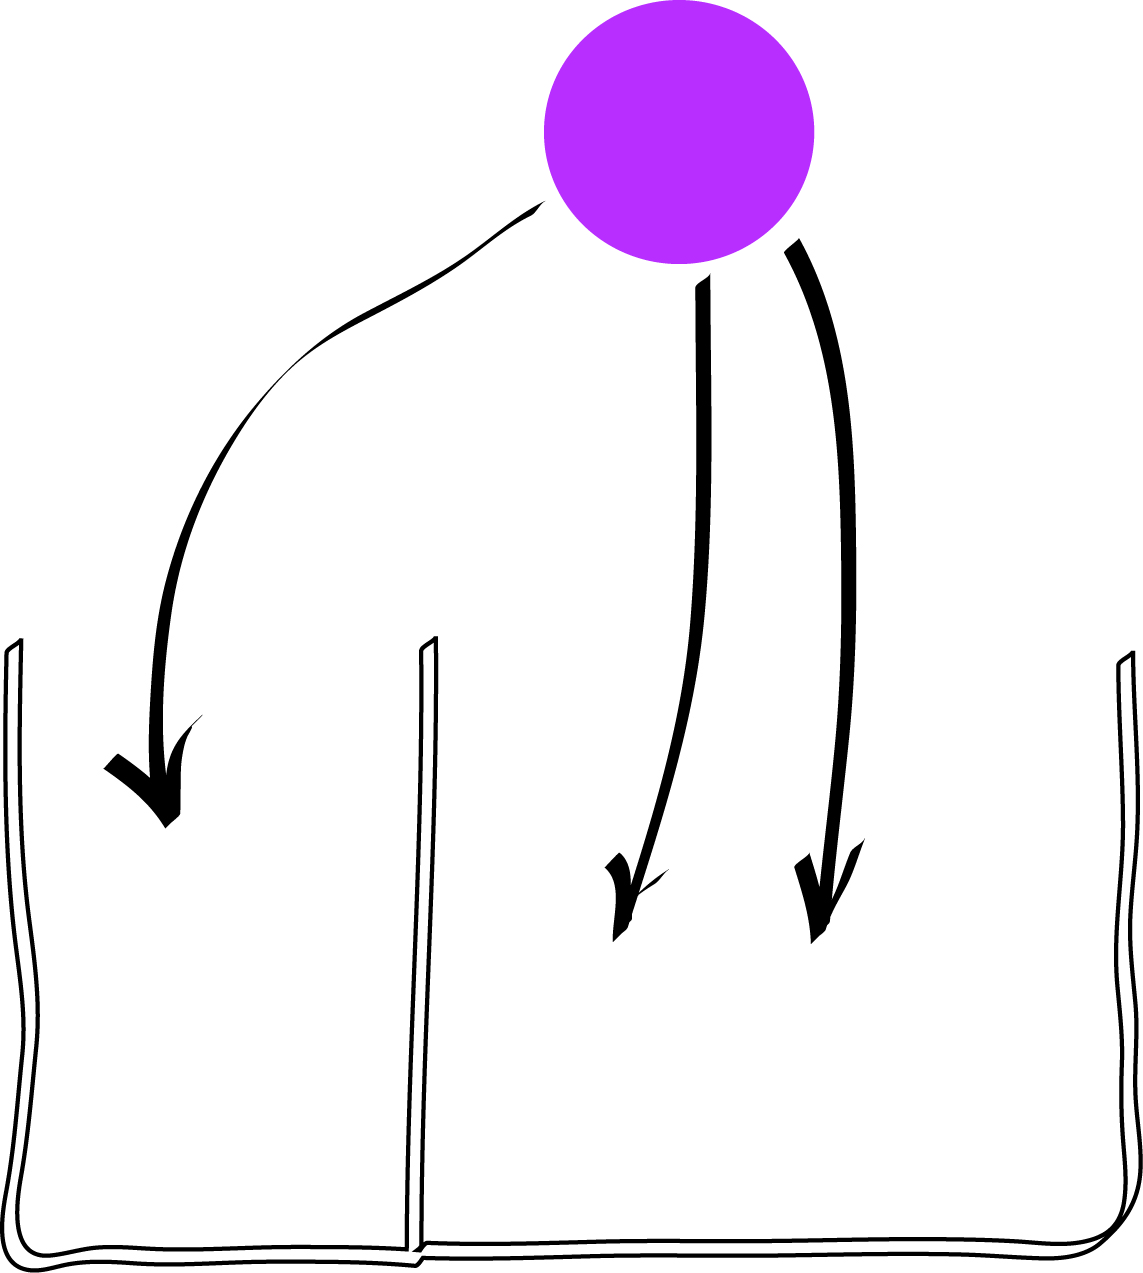

In [10]:
display(Image('http://web.stanford.edu/class/bios221/book/images/BallsinBoxes2.jpg',width=300, height=300))

> **Figure 1.2**: Two possible events with unequal probabilities. We model this by a Bernoulli distribution with probability parameter $p=\frac{2}{3}$.

We use the `bernoulli` function with a specific set of parameters. The first parameter, `size`, is the number of trials we want to observe; here we chose 15. We designate by `p` the probability of success.

Success and failure can have unequal probabilities in a Bernoulli trial, as long as the probabilities sum to 1 (We call such events complementary.). To simulate twelve trials of throwing a ball into the two boxes as shown in Figure 1.2, with probability of falling in the right-hand box $\frac{2}{3}$ and in the left-hand box $\frac{1}{3}$, we write:

In [11]:
bernoulli.rvs(size=15,p=2/3)

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1])

The 1 indicates success, meaning that the ball fell in the right-hand box, 0 means the ball fell in the left-hand box.

### 1.3.2. Binomial success counts

If we only care how many balls go in the right-hand box, then the order of the throws doesn’t matter (the exchangeability property), and we can get this number by just taking the sum of the cells in the output vector. Therefore, instead of the binary vector we saw above, we only need to report a single number. In Python, we can do this using one call to the binom function with the parameter `size` set to 1 and `n` set to 12:

In [12]:
from scipy.stats import binom
binom.rvs(n=12, size=1, p=2/3)

array([5])

This output tells us how many of the twelve balls fell into the right-hand box (the outcome that has probability 2/3). We use a random two-box model when we have only two possible outcomes such as heads or tails, success or failure, CpG or non-CpG, M or F, Y = pyrimidine or R = purine, diseased or healthy, true or false. We only need the probability of “success” $p$, because “failure” (the complementary event) will occur with probability $1-p$ . When looking at the result of several such trials, if they are exchangeable (one situation in which trials are exchangeable is if they are independent of each other.), we record only the number of successes. Therefore, $SSSSSFSSSSFFFSF$ is summarized as ( #Successes=10, #Failures=5 ), or as $x = 10, n = 15$.

The number of successes in 15 Bernoulli trials with a probability of success of 0.3 is called a binomial random variable or a random variable that follows the $B(15,0.3)$ distribution. To generate samples, we use a call to the `binom` function with the number of trials set to 15:

In [13]:
binom.rvs(n=15, size=1, p=.3)

array([5])

The complete probability mass distribution is available by typing:

In [14]:
binom.pmf(k=np.arange(15),n=15, p=0.3)

array([4.74756151e-03, 3.05200383e-02, 9.15601148e-02, 1.70040213e-01,
       2.18623131e-01, 2.06130381e-01, 1.47235986e-01, 8.11300333e-02,
       3.47700143e-02, 1.15900048e-02, 2.98028694e-03, 5.80575378e-04,
       8.29393397e-05, 8.20279184e-06, 5.02211745e-07])

or in rounded form:

In [15]:
np.around(binom.pmf(k=np.arange(15),n=15, p=0.3),decimals=3)

array([0.005, 0.031, 0.092, 0.17 , 0.219, 0.206, 0.147, 0.081, 0.035,
       0.012, 0.003, 0.001, 0.   , 0.   , 0.   ])

We can produce a bar plot of this distribution:

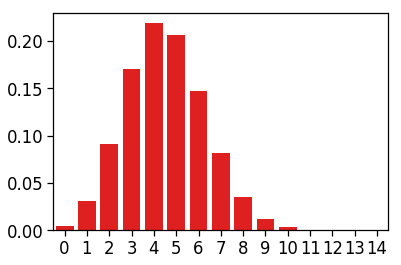

In [16]:
sns.barplot(x=np.arange(15), y=binom.pmf(k=np.arange(15),n=15, p=0.3), color='r')

Theoretical distribution of $B(15,0.3)$. The highest bar is at $x=4$. We have chosen to represent theoretical values in red throughout.

The number of trials is the number we input in Python as $n$, while the probability of success is $p$. Mathematical theory tells us that for $X$ distributed as a binomial distribution with parameters $(n, p)$ written $X \sim B(n,p)$, the probability of seeing $X = k$ successes is:

$P(X = k) = \binom{n}{k}p^k(1-p)^{n-k}$

where bionomial notation $\binom{n}{k} = \frac{n!}{(n-k)!k!}$

 &#9757; What is the output of the formula for $k=3$, $p=2/3$, $n=4$?

In [17]:
binom.pmf(k=3,p=2/3,n=4)

0.39506172839506176

### 1.3.3. Poisson distributions

When the probability of success $p$ is small and the number of trials $n$ large, the binomial distribution $B(n,p)$ can be faithfully approximated by a simpler distribution, the Poisson distribution with rate parameter $λ=np$. We already used this fact, and this distribution, in the HIV example above

 &#9757; What is the probability mass distribution of observing 0:12 mutations in a genome of $n=10^4$ nucleotides, when the probability is $p=5\times10^{−4}$ per nuceotide? Is it similar when modeled by the binomial $B(n,p)$ distribution and by the Poisson $(λ=np)$ distribution?

Note that, unlike the binomial distribution, the Poisson no longer depends on two separate parameters $n$ and $p$, but only on their product $np$. As in the case of the binomial distribution, we also have a mathematical formula for computing Poisson probabilities:

$P(X = k) = \frac{λ^ke^{-λ}}{k!}$

thus for our example above $λ = (5\times10^{-4})\times(10^4) = 5$ and the probability of observing, say, 3 mutations will be:


In [18]:
import math
5**3 * math.exp(-5) / math.factorial(3)

0.14037389581428056

or (in SciPy `mu` is used in place of λ):

In [19]:
poisson.pmf(k=3, mu=5)

0.1403738958142805

Let's now compare results of simulating data using bionomial and poisson distribution along 10,000 positions (this is our genome size) with a mutation rate of $5\times10^{-4}$. For binomial distribution is will be:

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


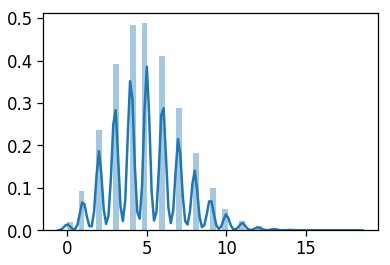

In [20]:
sns.distplot(binom.rvs(n=10000, p=5e-4, size=300000))

and for Poisson:

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


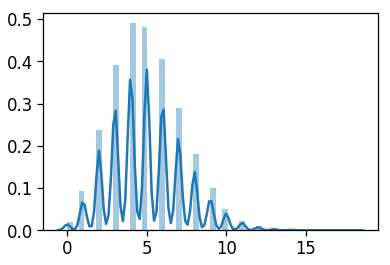

In [21]:
sns.distplot(poisson.rvs(mu=5,size=300000))

### 1.3.4. A generative model for epitope detection

When testing certain pharmaceutical compounds, it is important to detect proteins that provoke an allergic reaction. The molecular sites that are responsible for such reactions are called epitopes. The technical definition of an epitope is:

> A specific portion of a macromolecular antigen to which an antibody binds. In the case of a protein antigen recognized by a T-cell, the epitope or determinant is the peptide portion or site that binds to a Major Histocompatibility Complex (MHC) molecule for recognition by the T cell receptor (TCR).

And in case you’re not so familar with immunology: an antibody is a type of protein made by certain white blood cells in response to a foreign substance in the body, which is called the antigen.

An antibody binds (with more or less specificity) to its antigen. The purpose of the binding is to help destroy the antigen. Antibodies can work in several ways, depending on the nature of the antigen. Some antibodies destroy antigens directly. Others help recruit white blood cells to destroy the antigen. An epitope, also known as antigenic determinant, is the part of an antigen that is recognized by the immune system, specifically by antibodies, B cells or T cells.



#### ELISA error model with known parameters

[ELISA](http://en.wikipedia.org/wiki/ELISA) assays are used to detect specific epitopes at different positions along a protein. Suppose the following facts hold for an ELISA array we are using:

 - The baseline noise level per position, or more precisely the false positive rate, is 1%. This is the probability of declaring a hit – we think we have an epitope – when there is none. We write this $P(declare\ epitope | no\ epitope)$
 - The protein is tested at 100 different positions, supposed to be independent
 - We are going to examine a collection of 50 patient samples


#### One patient's data

The data for one patient’s assay look like this:

```
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0
```

where the 1 signifies a hit (and thus the potential for an allergic reaction), and the zeros signify no reaction at that position.

&#9757; Verify by simulation that the sum of 50 independent Bernoulli variables with $p = 0.01$ is –to good enough approximation– the same as a Poisson(0.5) random variable.

#### Results from 50 assays

We’re going to study the data for all 50 patients tallied at each of the 100 positions. If there are no allergic reactions, the false positive rate means that for one patient, each individual position has a probability of 1 in 100 of being a 1. So, after tallying 50 patients, we expect at any given position the sum of the 50 observed $(0,1)$ variables to have a Poisson distribution with parameter 0.5 ($0.01\times50=0.5$). Let's load the data:

In [22]:
!pip install pyreadr

In [23]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving e100.RData to e100 (1).RData
User uploaded file "e100.RData" with length 129 bytes


In [0]:
import pyreadr
df = pyreadr.read_r('e100.RData')['e100']

In [25]:
df.head()

,e100
0,2.0
1,0.0
2,1.0
3,0.0
4,0.0


and now let's visuzalise it:

([<matplotlib.axis.XTick at 0x7f9f3425a160>,
 <a list of 11 Text xticklabel objects>)

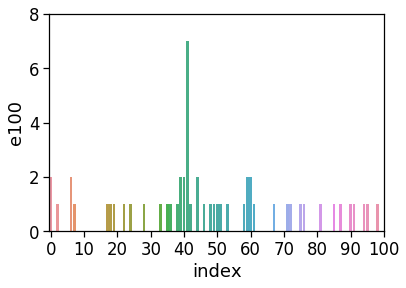

In [26]:
g = sns.barplot(data=df.reset_index(),x='index',y='e100')
g.set(ylim=(0,8))
ticks = np.arange(0, 101, step=10)
plt.xticks(ticks,ticks)

The spike in the figure above is striking. What are the chances of seeing a value as large as 7, if no epitope is present?
If we look for the probability of seeing a number as big as 7 (or larger) when considering one $Poisson(0.5)$ random variable, the answer can be calculated in closed form as:

$P(X\geq7)=\sum_{k=7}^\infty P(X=k)$

which is the same as $1-P(X\leq6)$. The probability $1-P(X\leq6)$ s the so-called cumulative distribution function at 6, and R has the function ppois for computing it, which we can use in either of the following two ways (Besides the convenience of not having to do the subtraction from one, the second of these computations also tends to be more accurate when the probability is small. This has to do with limitations of floating point arithmetic):

In [27]:
1-poisson.cdf(6,0.5)

1.0023796028768572e-06

above we use `poisson.cdf`, which is cumulative distribution function

In [28]:
poisson.sf(6,0.5)

1.0023796028842995e-06

and here we use `poisson.sf`, which is [survival function](https://en.wikipedia.org/wiki/Survival_function) defined as 1 - cdf.

We denote this number by $\epsilon$, the Greek letter epsilon (Mathematicians often call small numbers (and children) 
$\epsilon$). We have shown that the probability of seeing a count as large as $7$ , assuming no epitope reactions, is:

$\epsilon = (P\geq7) = 1-P(X\leq6)\simeq10^{-6}$

#### Extreme value analysis for the Poisson distribution

Stop! The above calculation is not the correct computation in this case. Can you spot the flaw in our reasoning if we want to compute the probability that we observe these data if there is no epitope? We looked at all 100 positions, looked for the largest value and found that it was 7. Due to this selection, a value as large as 7 is more likely to occur than if we only looked at one position.

So instead of asking what the chances are of seeing a Poisson(0.5) as large as 7, we should ask ourselves, what are the chances that the maximum of 100 Poisson(0.5) trials is as large as 7? We use extreme value analysis here (Meaning that we’re interested in the behavior of the very large or very small values of a random distribution, for instance the maximum or the minimum.). We order the data values $x_1,x_2,...,x_{100}$ and rename them  $x_{(1)},x_{(2)},...,x_{(100)}$ so that $x_{(1)}$ denotes the smallest and $x_{(100)}$ the largest of the counts over 100 positions. Together, $x_{(1)},x_{(2)},...,x_{(100)}$ are called **rank statistic** of this sample of 100 values. The maximum value being as large as 7 is the complementary event of having all 100 counts be smaller than or equal to 6. Two complementary events have probabilities that sum to 1. Because the positions are supposed to be independent, we can now do the computation (the notation with the $\prod$  is just a compact way to write the product of a series of terms, analogous to the $\sum$ for sums):

$P(x_{(100)}\geq7)=1-\prod_{i=1}^{100}P(x_i\leq6)$

Because we suppose each of these 100 events are independent, we can use our result from above:

$\prod_{i=1}^{100}P(x_i\leq6)=(P(x_i\leq6))^{100}=(1-\epsilon)^{100}$

#### Actually computing the numbers
We could just let Python compute the value of this number, $(1−\epsilon)^{100}$. For those interested in how such calculations can be shortcut through approximation, we give some details. These can be skipped on a first reading.

We recall from above that $\epsilon \simeq 10^{-6}$ is *much* smaller than 1. To compute the value of $(1−\epsilon)^{100}$ approximately, we can use the [binomial theorem](https://en.wikipedia.org/wiki/Binomial_theorem) and drop all “higher order” terms of $\epsilon$, i.e., all terms with $\epsilon^2,  \epsilon^3, ...$ because they are negligibly small compared to the remaining (“leading”) terms.

$(1-\epsilon)^{100}=\sum\limits_{k=0}^n\binom{n}{k}1^{n-k}(-\epsilon)^k=1-n\epsilon+\binom{n}{2}\epsilon^2-\binom{n}{3}\epsilon^3+...\simeq1-n\epsilon\simeq1-10^{-4} $

Another, equivalent, route goes by using the approximation $e^{-\epsilon}\simeq1-\epsilon$, which is the same as $log(1-\epsilon)\simeq-\epsilon$. Hence:

$(1-\epsilon)^{100}=e^{log((1-\epsilon)^{100})}=e^{100log(1-\epsilon)}\simeq e^{-100\epsilon}\simeq e^{-10^{-4}}\simeq 1 - 10^{-4}$.

Thus the correct probability of seeing a number of hits as large or larger than 7 in the 100 positions, if there is no epitope, is about 100 times the probability we wrongly calculated previously. Both computed probabilities $10^{−6}$ and $10^{−4}$ are smaller than standard significance thresholds (say, $0.05$, $0.01$ or 
$0.001$). The decision to reject the null of no epitope would have been the same. However if one has to stand up in court and defend the $p$-value to 8 significant digits as in some forensic court cases(this occurred in the examination of the forensic evidence in the OJ Simpson case.) that is another matter. The adjusted $p$-value that takes into account the multiplicity of the test is the one that should be reported, and we will return to this important issue in the next several lectures.

#### Computing probabilities by simulation

In the case we just saw, the theoretical probability calculation was quite simple and we could figure out the result by an explicit calculation. In practice, things tend to be more complicated, and we are better to compute our probabilities using the **[Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method)** method: a computer simulation based on our generative model that finds the probabilities of the events we’re interested in. Below, we generate 1,000,000 instances of picking the maximum from 100 Poisson distributed numbers.

In [0]:
maxes = np.array([max(poisson.rvs(mu=0.5,size=100)) for i in range(100000)])

In [0]:
y,x = np.histogram(maxes,bins=[0,1,2,3,4,5,6,7,8,9])

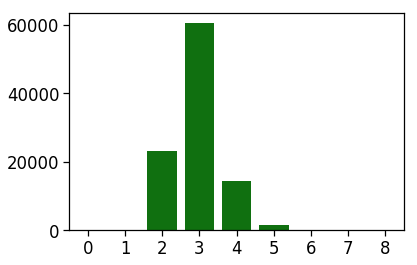

In [31]:
# Here we use x[:9] because bin array returned by numpy.histogram is one element longer than histogram array
sns.barplot(x=x[:9], y=y, color='g')

In [32]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [33]:
y

array([    0,     9, 23257, 60533, 14528,  1548,   113,    12,     0])

In ~100 of 1,000,000 trials, the maximum was 7 or larger. This gives the following approximation for $P(X_{max}\geq7)$:

In [34]:
np.shape(maxes[maxes>=7])[0]/1000000

1.2e-05

In [35]:
103/1000000

0.000103

which more or less agrees with our theoretical calculation. We already see one of the potential limitations of Monte Carlo simulations: the “granularity” of the simulation result is determined by the inverse of the number of simulations (100000) and so will be around $10^{-5}$. Any estimated probability cannot be more precise than this granularity, and indeed the precision of our estimate will be a few multiples of that. Everything we have done up to now is only possible because we know the false positive rate per position, we know the number of patients assayed and the length of the protein, we suppose we have identically distributed independent draws from the model, and there are no unknown parameters (we postulated the Poisson distribution for the noise, pretending we knew all the parameters and were able to conclude through mathematical deduction). This is an example of **probability** or **generative modeling**: all the parameters are known and the mathematical theory allows us to work by deduction in a top-down fashion.

If instead we are in the more realistic situation of knowing the number of patients and the length of the proteins, but don’t know the distribution of the data, then we have to use statistical modeling. This approach will be developed in the next chapter. We will see that if we have only the data to start with, we first need to **fit** a reasonable distribution to describe it. However, before we get to this harder problem, let’s extend our knowledge of discrete distributions to more than binary, success-or-failure outcomes.

## 1.4. Multinomial distributions: the case for DNA


#### More than two outcomes

When modeling four possible outcomes, as for instance the boxes in Figure 1.9 or when studying counts of the four nucleotides A,C,G and T, we need to extend the binomial model.

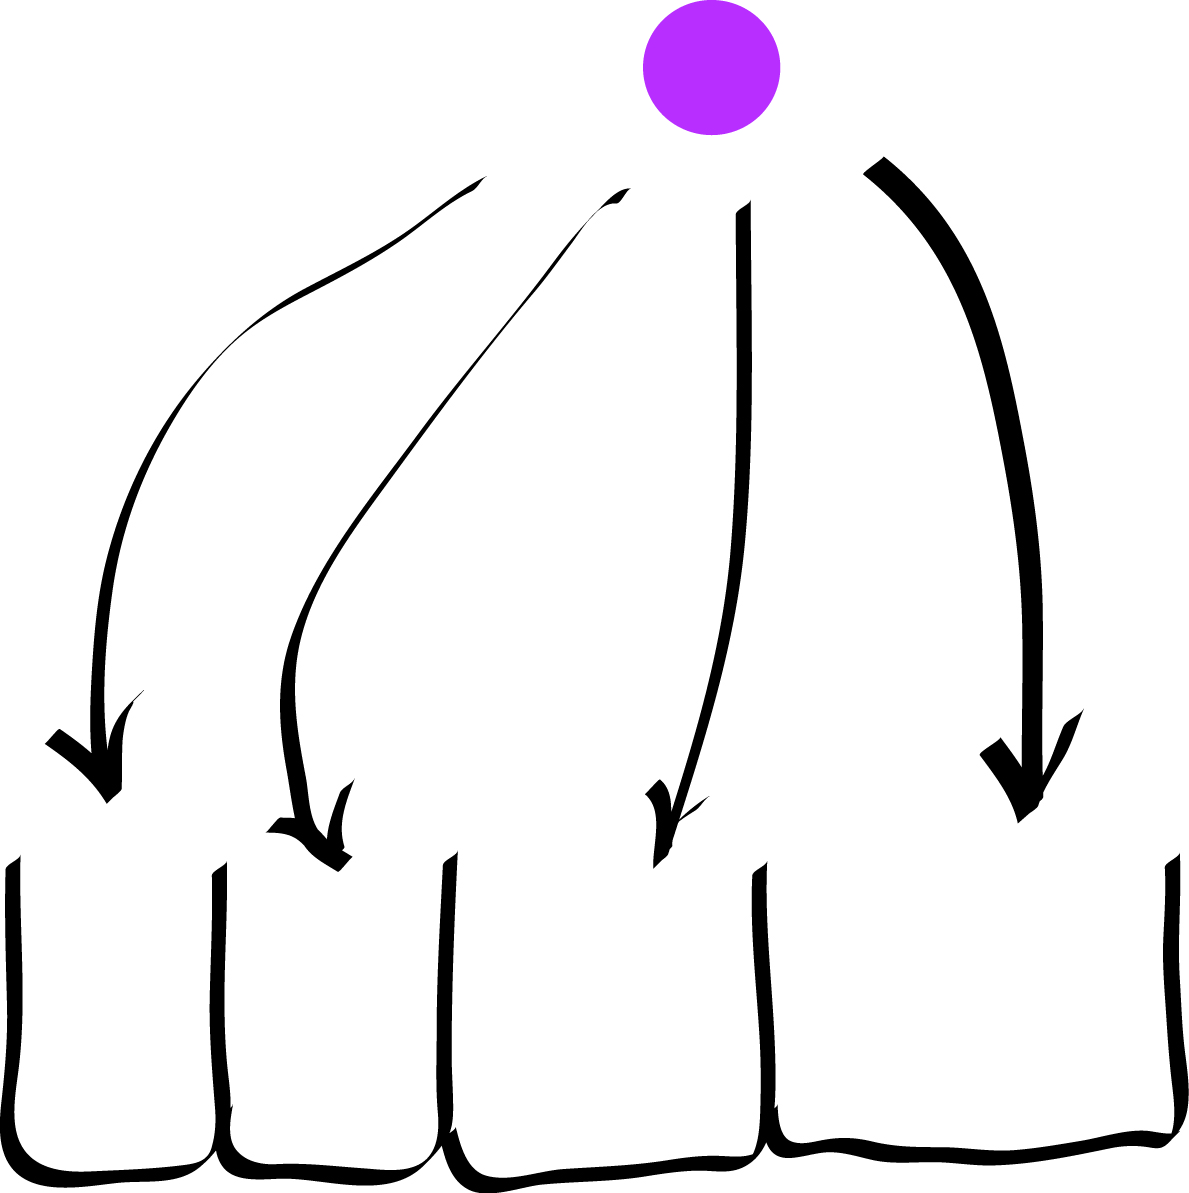

In [36]:
display(Image('https://www.huber.embl.de/msmb/images/BallsinBoxes4.jpg',width=300, height=300))

>Figure 1.9: The boxes represent four outcomes or levels of a discrete categorical variable. The box on the right represents the more likely outcome.

Recall that when using the binomial, we can consider unequal probabilities for the two outcomes by assigning a probability $p=P(1)=p_1$ to th eoutcome 1 and $1-p=p(0)=p_0$ to th eoutcome 0. When there are more than two possible outcomes, say A,C,G and T, we can think of throwing balls into boxes of differing sizes corresponding to different probabilities, and we can label these probabilites $p_A$, $p_C$, $p_G$, $p_T$. Just as in the binomial case the sum of the probabilities of all possible outcomes is $p_A + p_C + p_G + p_T = 1$.

Experiment with the random number generator that generates all possible numbers between 0 and 1 through the function called runif. Use it to generate a random variable with 4 levels (A, C, G, T) where $p_A=\frac{1}{8}$,$p_C=\frac{3}{8}$, $p_G=\frac{3}{8}$, $p_T=\frac{1}{8}$. To do this build on the following expression:

In [37]:

from scipy.stats import uniform
uniform.rvs(loc=0, scale=8)

3.6864696357954596

#### Mathematics formulation



Multinomial distributions are the most important model for tallying counts and Python uses a general formula to compute the probability of a multinomial vector of counts $(x_1,...,x_m)$ for outcomes that have $m$ boxes with probabilities $p_1,...,p_m$:

$P(x_1,x_2,...,x_m | p_1, p_2, ... ,p_m) = \binom{n}{x_1,x_2,...,x_m}p_1^{x_1}p_2^{x_2}...p_m^{x_m}$

 &#9757; Suppose we have four boxes that are equally likely. Using the formula, what is the probability of observing 4 in the first box, 2 in the second box, and none in the two other boxes?
 
 $P(4,2,0,0) = \frac{6!}{4!2!}\times(\frac{1}{4})^6=\frac{15}{4^6}\simeq0.0037$
 
 or in Python:


In [38]:
from scipy.stats import multinomial
multinomial.pmf(x=(4,2,0,0),n=6,p=[0.25]*4)

0.003662109374999998

We often run simulation experiments to check whether the data we see are consistent with the simplest possible four-box model where each box has the same probability 1/4. In some sense it is the strawman (nothing interesting is happening). We’ll see more examples of this in the next lecture. Here we use a few R commands to generate such vectors of counts. First suppose we have 8 characters of four different, equally likely types:

In [39]:
pvec=[1/4]*4
multinomial.rvs(n=8,p=pvec,size=1)

array([[4, 1, 1, 2]])

&#9757;  How do you interpret the difference between `multinomial.rvs(n=8,p=pvec,size=1)` and `multinomial.rvs(n=1,p=pvec,size=8)`?

### 1.4.1. Simulating for power



Let’s see an example of using Monte Carlo for the multinomial in a way which is related to a problem scientists often have to solve when planning their experiments: how big a sample size do I need?

The term power has a special meaning in statistics. It is the probability of detecting something if it is there, also called the true positive rate.

Conventionally, experimentalists aim for a power of 80% (or more) when planning experiments. This means that if the same experiment is run many times, about 20% of the time it will fail to yield significant results even though it should.

Let’s call $H_0$  the null hypothesis that the DNA data we have collected comes from a fair process, where each of the 4 nucleotides is equally likely $(p_A,p_C,p_G,p_T)=(0.25,0.25,0.25,0.25)$

Null here just means: the baseline, where nothing interesting is going on. It’s the strawman that we are trying to disprove (or “reject”, in the lingo of statisticians), so the null hypothesis should be such that deviations from it are interesting 

>If you know a little biology, you will know that DNA of living organisms rarely follows that null hypothesis – so disproving it may not be all that interesting. Here we proceed with this null hypothesis because it allows us to illustrate the calculations, but it can also serve us as a reminder that the choice of a good null hypothesis (one whose rejection is interesting) requires scientific input)

As you saw by running the Python commands for 8 characters and 4 equally likely outcomes, represented by equal-sized boxes, we do not always get 2 in each box. It is impossible to say, from looking at just 8 characters, whether the nucleotides come from a fair process or not.

Let’s determine if, by looking at a sequence of length $n=20$, we can detect whether the original distribution of nucleotides is fair or whether it comes from some other (“alternative”) process.

We generate 1000 simulations from the null hypothesis using the rmultinom function. We display only the first 11 columns to save space.

In [0]:
obsunder0 = np.transpose(multinomial.rvs(n=20,p=pvec,size=1000))

In [41]:
obsunder0.shape

(4, 1000)

In [42]:
obsunder0[:,:11]

array([[6, 4, 5, 6, 1, 2, 5, 6, 1, 6, 4],
       [4, 3, 5, 6, 8, 6, 3, 1, 6, 5, 5],
       [7, 6, 3, 3, 6, 4, 4, 9, 4, 1, 3],
       [3, 7, 7, 5, 5, 8, 8, 4, 9, 8, 8]])

Each column in the matrix `obsunder0` is a simulated instance. You can see that the numbers in the boxes vary a lot: some are as big as 10, whereas the expected value is $5=20/4$.

#### Creating a test

Remember: we know these values come from a fair process. Clearly, knowing the process’ expected values isn’t enough. We also need a measure of variability that will enable us to describe how much variability is expected and how much is too much. We use as our measure the following statistic, which is computed as the sum of the squares of the differences between the observed values and the expected values relative to the expected values (This measure weights each of the square residuals relative to their expected values.). Thus, for each instance,

$stat=\frac{(E_A-x_A)^2}{E_A}+\frac{(E_C-x_C)^2}{E_C}+\frac{(E_G-x_G)^2}{E_G}+\frac{(E_T-x_T)^2}{E_T}=\sum_i\frac{(E_i-x_i)^2}{E_i}\ \ \  (1.1)$

How much do the first three columns of the generated data differ from what we expect? We get:

In [0]:
pvec=np.array(pvec)

In [0]:
expected0 = np.array(pvec*20)

In [45]:
expected0

array([5., 5., 5., 5.])

In [46]:
expected0.shape

(4,)

In [47]:
obsunder0.shape

(4, 1000)

In [48]:
np.sum((obsunder0[:,0] - expected0)**2 / expected0)

2.0

In [49]:
np.sum((obsunder0[:,1] - expected0)**2 / expected0)

2.0

In [50]:
np.sum((obsunder0[:,2] - expected0)**2 / expected0)

1.6

In [51]:
np.sum((obsunder0[:,3] - expected0)**2 / expected0)

1.2000000000000002

The values of the measure can differ: you can look at a few more than 3 columns, we’re going to see how to study all 1,000 of them. To avoid repetitive typing, we encapsulate the formula for stat, Equation (1.1), in a loop. To this we will first initialize a vector `S0` that will hold the values for our statistics fror all 1000 instances:

In [0]:
S0 = np.zeros(1000)

In [0]:
for i in range(obsunder0.shape[1]):
  S0[i] = np.sum((obsunder0[:,i] - expected0)**2 / expected0)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


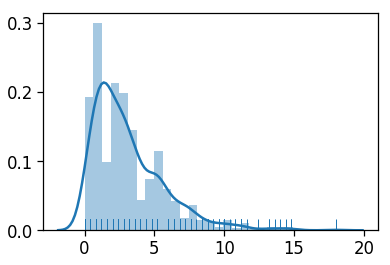

In [54]:
sns.distplot(S0, rug=True)

>The histogram of simulated values S0 of the statistic stat under the null (fair) distribution provides an approximation of the sampling distribution of the statistic stat.

The summary function shows us that `S0` takes on a spread of different values. From the simulated data we can approximate, for instance, the 95% quantile (a value that separates the smaller 95% of the values from the 5% largest values).

In [55]:
from scipy.stats import describe
describe(S0)

DescribeResult(nobs=1000, minmax=(0.0, 18.0), mean=3.1243999999999996, variance=6.501105745745745, skewness=1.561329737042596, kurtosis=3.340408851404738)

In [58]:
np.quantile(S0, 0.95)

7.6000000000000005

So we see that 5% of the `S0` values are larger than 7.6. We’ll propose this as our critical value for testing data and will reject the hypothesis that the data come from a fair process, with equally likely nucleotides, if the weighted sum of squares stat is larger than 7.6.

#### Determining test power

We must compute the probability that our test –based on the weighted sum-of-square differences– will detect that the data in fact do not come from the null hypothesis. We compute the probability of rejecting by simulation. We generate 1000 simulated instances from an alternative process, parameterized by `pvecA`:

In [0]:
pvecA=np.array([3/8,1/4,3/12,1/8])

In [109]:
pvecA

array([0.375, 0.25 , 0.25 , 0.125])

In [0]:
observed = np.transpose(multinomial.rvs(n=20,p=pvecA,size=1000))

In [111]:
observed.shape

(4, 1000)

In [112]:
observed[:,:7]

array([[ 8,  8,  8,  5,  7,  7,  7],
       [ 5,  0,  5,  4,  4,  5,  6],
       [ 6,  7,  6, 10,  6,  4,  4],
       [ 1,  5,  1,  1,  3,  4,  3]])

In [113]:
np.mean(observed,axis=1)

array([7.5  , 4.979, 4.995, 2.526])

In [0]:
expectedA = pvecA*20

In [115]:
expectedA

array([7.5, 5. , 5. , 2.5])

As with the simulation from the null hypothesis, the observed values vary considerably. The question is: how often (out of 1000 instances) will our test detect that the data depart from the null?

The test doesn’t reject the first observation: because the value of the statistic is within the 95th percentile.

In [116]:
observed[:,0]

array([8, 5, 6, 1])

because the value of the statistic is within the 95th percentile:

In [117]:
np.sum((observed[:,0] - expectedA)**2 / expectedA)

1.1333333333333333

In [0]:
S1 = np.zeros(1000)

In [0]:
for i in range(observed.shape[1]):
  S1[i] = np.sum((observed[:,i] - expectedA)**2 / expectedA)

In [120]:
S1[1:10]

array([8.33333333, 1.13333333, 6.93333333, 0.53333333, 1.13333333,
       0.53333333, 2.2       , 1.93333333, 4.93333333])

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


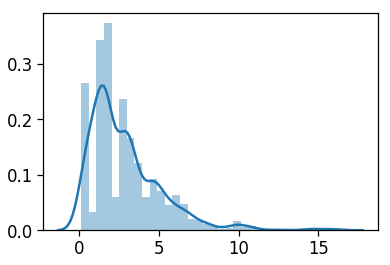

In [121]:
sns.distplot(S1)

In [0]:
q95 = np.quantile(S1, 0.95)

In [123]:
q95

6.933333333333334

In [124]:
np.sum(S1 > q95)

48

In [125]:
power = np.mean(S1 > q95)
power

0.048

Run across 1000 simulations, the test identified 199 as coming from an alternative distribution. We’ve thus computed that the probability $P(reject\ H_0 | H_A)$ is 0.048.

We read the vertical line as given or conditional on.

With a sequence length of $n=20$ we have a power of about 5% to detect the difference between the fair generating process and our alternative.

In practice, as we mentioned, an acceptable value of power is  0.8 or more. Repeat the simulation experiments and suggest a new sequence length 
$n$ that will ensure that the power is acceptable.

#### Classical statistics for classical data

We didn’t need to simulate the data using Monte Carlo to compute the 95th percentiles; there is an adequate theory to help us with the computations.

Our statistic stat actually has a well-known distribution called the chi-square distribution (with 3 degrees of freedom) and written $\chi_3^2$3.

We will see in the next lecture how to compare distributions using Q-Q plots. We could have used a more standard test instead of running a hand-made simulation. However, the procedure we’ve learned extends to many situations in which the chi-square distribution doesn’t apply. For instance, when some of the boxes have extremely low probabilities and their counts are mostly zero.

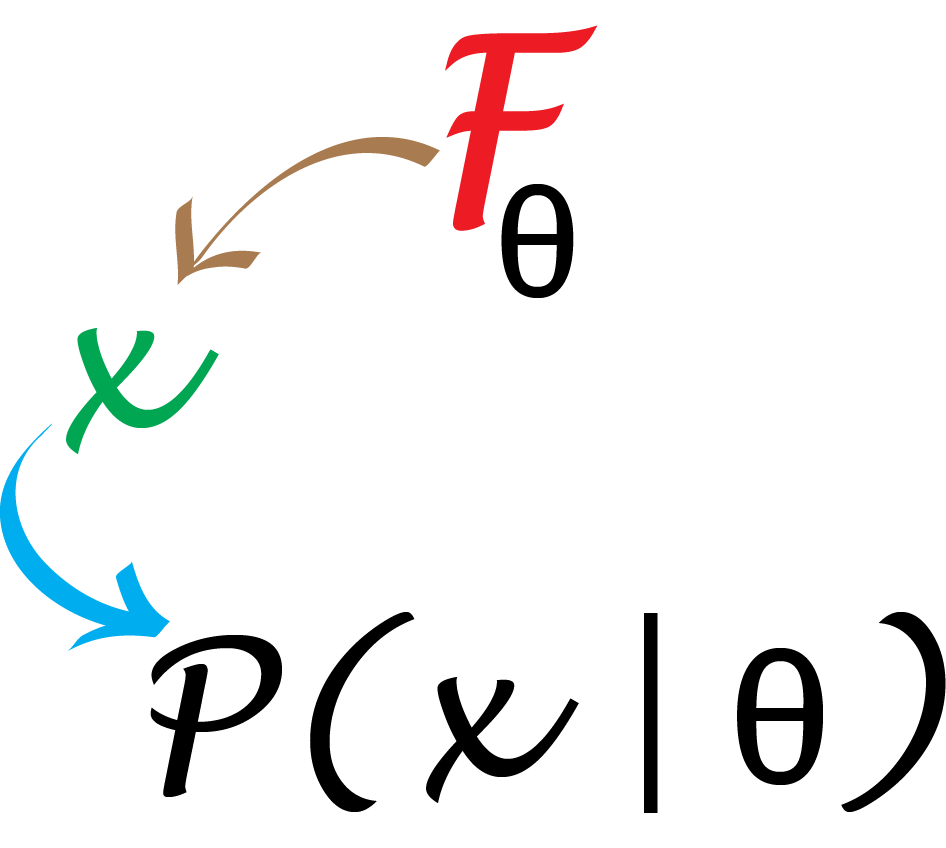

In [135]:
display(Image('http://web.stanford.edu/class/bios221/book/images/ProbaDiagram.png',width=300, height=300))

>We have studied how a probability model has a distribution we call this $F$. $F$ often depends on parameters, which are denoted by Greek letters, such as 
$\theta$. The observed data are generated via the brown arrow and are represented by Roman letters such as $x$. The vertical bar in the probability computation stands for supposing that or conditional on.

## 1.5. Summary of this chapter

We have used mathematical formulæ and Python to compute probabilities of various discrete events that can we modeled with a few basic distributions: The Bernoulli distribution was our most basic building block – it is used to represent a single binary trial such as a coin flip. We can code the outcomes as 0 and 1. We call $p$ the probability of success (the 1 outcome).

The binomial distribution is used for the number of 1s in $n$ binary trial and we generate the probabilities of seeing $k$
successes using the Python `scipy.stats` function `binom`. We also saw that we could simulate an `n`  trial binomial using the function `binom.rvs`.

The Poisson distribution is most appropriate for cases when $p$ is small (the 1s are rare). It has only one parameter $\lambda$, and the Poisson distribution for $\lambda = np$ is approximately the same as the binomial distribution for $(n, p)$ if $p$ is small. We used the Poisson distribution to model the number of randomly occuring false positives in an assay that tested for epitopes along a sequence, presuming that the per-position false positive rate $p$
 was small. We saw how such a parametric model enabled us to compute the probabilities of extreme events, as long as we knew all the parameters.

The multinomial distribution is used for discrete events that have more than two possible outcomes or levels. The power example showed us how to use Monte Carlo simulations to decide how much data we need to collect if we want to test whether a multinomial model with equal probabilities is consistent with the data. We used probability distributions and probabilistic models to evaluate hypotheses about how our data were generated, by making assumptions about the generative models. We term the probability of seeing the data, given a hypothesis, a $p$-value. This is not the same as the probability that the hypothesis is true!

## 1.6. Further reading


 - The elementary book by Freedman, Pisani, and Purves (1997) provides the best introduction to probability through the type of box models we mention here (Freedman, David, Robert Pisani, and Roger Purves. 1997. Statistics. New York, NY: WW Norton.).
 - The book by Durbin et al. (1998) covers many useful probability distributions and provides in its appendices a more complete view of the theoretical background in probability theory and its applications to sequences in biology. (Durbin, Richard, Sean Eddy, Anders Krogh, and Graeme Mitchison. 1998. Biological Sequence Analysis. Cambridge University Press.)
 - Chapter 6 will cover the subject of hypothesis testing. We also suggest Rice (2006) for more advanced material useful for the type of more advanced probability distributions, beta, gamma, exponentials we often use in data analyses. (Rice, John. 2006. Mathematical Statistics and Data Analysis. Cengage Learning.)

